In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

import sklearn
from sklearn.svm import SVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import GridSearchCV

import tensorflow as tf


np.random.seed(0)
tf.random.set_seed(0)

In [ ]:
!git clone https://github.com/MLinApp-FP01-Team7-24/OurProject.git
%cd OurProject

Cloning into 'OurProject'...
remote: Enumerating objects: 2067, done.
remote: Counting objects: 100% (15/15), done.
remote: Compressing objects: 100% (11/11), done.
remote: Total 2067 (delta 7), reused 6 (delta 4), pack-reused 2052 (from 1)
Receiving objects: 100% (2067/2067), 372.52 MiB | 13.31 MiB/s, done.
Resolving deltas: 100% (430/430), done.
Updating files: 100% (999/999), done.
/content/OurProject


In [ ]:
window_size = 20
k_pa = 1 # valori tra 0 e 1

In [ ]:
from Models.lstm_vae.data import get_data_windows

data_train, data_cal, label_cal, data_test, label_test = get_data_windows(window_size, k_pa)

print(data_train.shape)
print(data_cal.shape, label_cal.shape)
print(data_test.shape, label_test.shape)


Reading training data...
Reading calibration data...
Reading test data...
Reading collisions data...
Normalizing data...
Getting windows for training data...
Getting windows and labels for calibration data...
Getting windows and labels for test data...
(95795, 20, 55)
(3480, 20, 55) (3480,)
(30755, 20, 55) (30755,)


In [ ]:
x_dim = data_train.shape[2]
lstm_h_dim = 10
z_dim = 10

batch_size = 64
epoch_num = 20

In [ ]:
from Models.lstm_vae.model import LSTM_VAE

opt = tf.keras.optimizers.Adam(epsilon=1e-6, amsgrad=True)
scheduler = tf.keras.callbacks.LearningRateScheduler(lambda x: 1e-3 * 0.9 ** x)

X_train = tf.convert_to_tensor(data_train, dtype='float32')
train_dataset = tf.data.Dataset.from_tensor_slices(X_train)
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(batch_size, drop_remainder=True)

model = LSTM_VAE(window_size, x_dim, lstm_h_dim, z_dim, dtype='float32')
model.compile(optimizer=opt)
history = model.fit(train_dataset, epochs=epoch_num, shuffle=False, callbacks=[scheduler]).history
model.summary()
model.save_weights('./lstm_vae_ckpt.weights.h5')

Epoch 1/20
1496/1496 ━━━━━━━━━━━━━━━━━━━━ 27s 15ms/step - loss: 0.4482 - learning_rate: 0.0010
Epoch 2/20
1496/1496 ━━━━━━━━━━━━━━━━━━━━ 22s 15ms/step - loss: 0.1134 - learning_rate: 9.0000e-04
Epoch 3/20
1496/1496 ━━━━━━━━━━━━━━━━━━━━ 23s 15ms/step - loss: 0.1120 - learning_rate: 8.1000e-04
Epoch 4/20
1496/1496 ━━━━━━━━━━━━━━━━━━━━ 22s 15ms/step - loss: 0.1114 - learning_rate: 7.2900e-04
Epoch 5/20
1496/1496 ━━━━━━━━━━━━━━━━━━━━ 24s 16ms/step - loss: 0.1111 - learning_rate: 6.5610e-04
Epoch 6/20
1496/1496 ━━━━━━━━━━━━━━━━━━━━ 22s 15ms/step - loss: 0.1111 - learning_rate: 5.9049e-04
Epoch 7/20
1496/1496 ━━━━━━━━━━━━━━━━━━━━ 21s 14ms/step - loss: 0.1111 - learning_rate: 5.3144e-04
Epoch 8/20
1496/1496 ━━━━━━━━━━━━━━━━━━━━ 42s 15ms/step - loss: 0.1113 - learning_rate: 4.7830e-04
Epoch 9/20
1496/1496 ━━━━━━━━━━━━━━━━━━━━ 41s 15ms/step - loss: 0.1115 - learning_rate: 4.3047e-04
Epoch 10/20
1496/1496 ━━━━━━━━━━━━━━━━━━━━ 21s 14ms/step - loss: 0.1119 - learning_rate: 3.8742e-04
Epoch 11/20
1

Model: "lstm_vae"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ encoder (Encoder)                    │ ?                           │           2,860 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ decoder (Decoder)                    │ ?                           │           1,445 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 17,222 (67.28 KB)

 Trainable params: 4,305 (16.82 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 12,917 (50.46 KB)

In [ ]:
from google.colab import files

# files.download('./lstm_vae_ckpt.data-00000-of-00001')
# files.download('./lstm_vae_ckpt.index')
files.download('./lstm_vae_ckpt.weights.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
score_cal = model.anomaly_score(data_cal)
label_cal = label_cal[:score_cal.shape[0]]

54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step


In [ ]:
optimize = True
param_grid = {'estimator__C': np.logspace(0, 5, 6), 'estimator__gamma': np.logspace(-5, 0, 6)}

if optimize:
  cal_search = GridSearchCV(CalibratedClassifierCV(SVC(probability=True), cv=3), param_grid, cv=3, verbose=1, scoring='f1')
  cal_search.fit(score_cal, label_cal)
  cal_model = cal_search.best_estimator_
  print(cal_search.best_params_)
else:
  cal_model = CalibratedClassifierCV(SVC(probability=True, C=1, gamma=0.0001))
  cal_model.fit(score_cal, label_cal[:score_cal.shape[0]])

Fitting 3 folds for each of 36 candidates, totalling 108 fits
{'estimator__C': 1.0, 'estimator__gamma': 0.0001}


In [ ]:
score_test = model.anomaly_score(data_test)
label_test = label_test[:score_test.shape[0]]

y_pred_test = cal_model.predict(score_test)
y_score_test = cal_model.predict_proba(score_test)[:, 1]

480/480 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step


In [ ]:
f1 = sklearn.metrics.f1_score(label_test, y_pred_test)
f1

0.40770791075050705

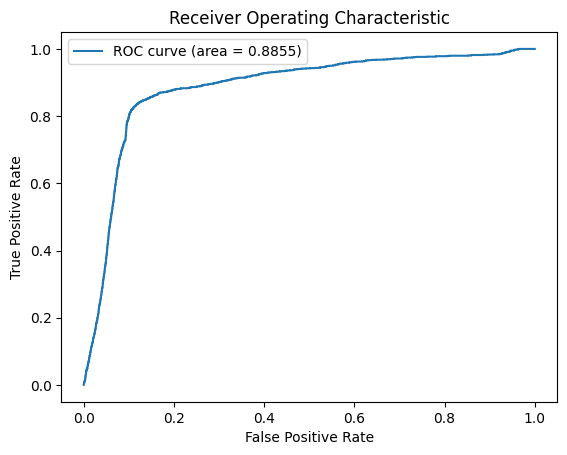

0.8855472620093648

In [ ]:
fpr, tpr, thresholds = sklearn.metrics.roc_curve(label_test, y_score_test)
roc_auc = sklearn.metrics.auc(fpr, tpr)

plt.plot(fpr, tpr, label='ROC curve (area = %0.4f)' % roc_auc)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend()
plt.show()

roc_auc

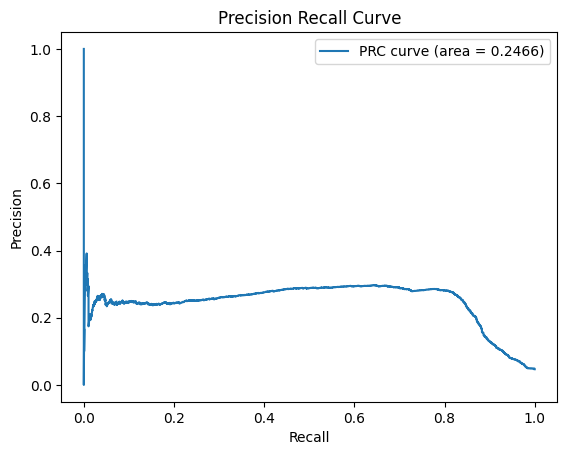

0.2466133115953229

In [ ]:
precison, recall, thresholds = sklearn.metrics.precision_recall_curve(label_test, y_score_test)
prc_auc = sklearn.metrics.auc(recall, precison)

plt.plot(recall, precison, label='PRC curve (area = %0.4f)' % prc_auc)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision Recall Curve')
plt.legend()
plt.show()

prc_auc